# GPU resource optimization

We know from early experiments with pre-embedding texts for indexing into OpeSearch that increasing the embedding batch size does not have a net performance benefit.

Now, the idea is to try embedding several small batches in parallel to see if we can get a speed-up that way.

## 1. Run set-up

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

# Standard imports
import time

# PyPI imports
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Internal imports
import configuration as config
import functions.notebook_helper as helper_funcs

Working directory: /mnt/arkk/opensearch/semantic_search


In [8]:
input_file_path=f'{config.DATA_PATH}/wikipedia-sample/{config.PARSED_TEXT}'

# Estimated total chunks after semantic splitting, determined in
# semantic splitting notebook
estimated_total_chunks=20648877

# GPU to assign work to
worker_gpu=['cuda:0']

# Numbers of workers per GPU to test
gpu_worker_counts=[1,2,3,4,5,6]

# Number of texts to send for embedding at a time
embedding_batch_size=1

# Number of batches to send to each worker for each round
batches_per_round=200

# Number of rounds to run for each worker count
rounds=3

# Holder for results
results={}

# Open a connection to the input data
input_data=h5py.File(input_file_path, 'r')

# Ingest all of the parsed sample data so we don't have to mess around
# with accumulating batches for the workers from input batches
record_count=0
texts=[]

# Loop on the batches
for batch_num in input_data['batches']:

    # Grab the batch from the hdf5 connection
    batch=input_data[f'batches/{batch_num}']

    # Strings come out of hdf5 as bytes, decode them
    for text in batch:
        record_count+=1
        texts.append(text.decode('utf-8'))

input_data.close()

if (batches_per_round*embedding_batch_size*max(gpu_worker_counts)) > len(texts):
    print(f'Warning: input text requirement is larger that input data.')

In [9]:
%%time

# Loop on the worker counts
for n_workers in gpu_worker_counts:
    print(f'Embedding with {n_workers} GPU workers.')

    # Build the GPU list for this worker count
    worker_gpus=worker_gpu*n_workers

    # Add the worker count as key to results
    results[f'{n_workers}']=[]

    for embedding_round in range(rounds):

        # Collect a set of embedding batches, one batch for each worker
        i=0
        embedding_batches=[]

        while len(embedding_batches) < n_workers:
            embedding_batch=texts[i:i + (embedding_batch_size*batches_per_round)]
            embedding_batches.append(embedding_batch)
            i+=(embedding_batch_size*batches_per_round)

        # Start the timer
        start_time = time.time()

        # Send the batches
        batch_count=helper_funcs.submit_batches(worker_gpus, embedding_batches, embedding_batch_size)
        
        # Stop the timer
        dT=time.time() - start_time # pylint: disable = invalid-name

        # Calculate the embedding rate
        embedding_rate=(n_workers * embedding_batch_size * batches_per_round) / dT

        # Add it to the results
        results[f'{n_workers}'].append(embedding_rate)

print()

Embedding with 1 GPU workers.
Embedding with 2 GPU workers.
Embedding with 3 GPU workers.
Embedding with 4 GPU workers.
Embedding with 5 GPU workers.
Embedding with 6 GPU workers.

CPU times: user 674 ms, sys: 1.1 s, total: 1.77 s
Wall time: 4min 18s


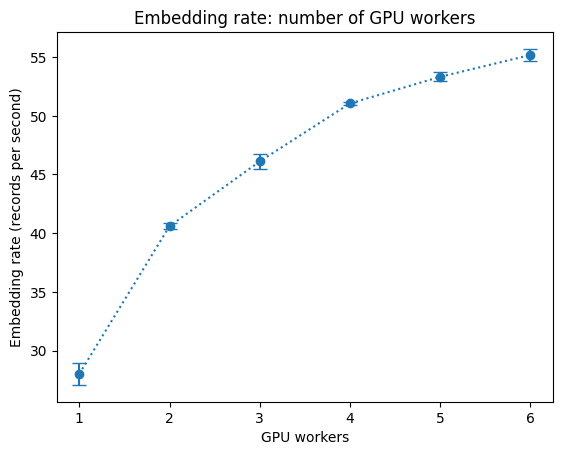

In [10]:
plt.title('Embedding rate: number of GPU workers')
plt.xlabel('GPU workers')
plt.ylabel('Embedding rate (records per second)')

standard_deviations=[]
means=[]

for batch_size in gpu_worker_counts:
    times=results[f'{batch_size}']
    means.append(np.mean(times))
    standard_deviations.append(np.std(times))

plt.errorbar(
    gpu_worker_counts, 
    means, 
    yerr=standard_deviations, 
    linestyle='dotted',
    marker='o', 
    capsize=5
)

#plt.yscale('log')

plt.show()


Let's see how long it would take to embed the whole dataset with 6 workers on a GTX1070.

In [11]:
mean_embedding_rate=sum(results['6']) / len(results['6'])
print(f'Estimated total embedding time: {(estimated_total_chunks / mean_embedding_rate) / (60*60*24):.2f} days')
print(f'Mean embedding rate: {mean_embedding_rate:.0f} records per second')

Estimated total embedding time: 4.33 days
Mean embedding rate: 55 records per second


OK, so - it looks like we are speeding up the embedding by using multiple workers. But we are going slower than with a single process, even with six workers, probably because of the overhead associated with running multiple workers. Definitely not worth doing it this way.

Let's try it with one worker on each of the three GPUs in the system.

In [12]:
%%time

# Build the GPU list
worker_gpus=['cuda:0','cuda:1','cuda:2']
n_workers=len(worker_gpus)

# Holder for results
results=[]

# Run replicates
for embedding_round in range(rounds):

    # Collect a set of embedding batches, one batch for each worker
    i=0
    embedding_batches=[]

    while len(embedding_batches) < n_workers:
        embedding_batch=texts[i:i + (embedding_batch_size*batches_per_round)]
        embedding_batches.append(embedding_batch)
        i+=(embedding_batch_size*batches_per_round)

    # Start the timer
    start_time = time.time()

    # Send the batches
    batch_count=helper_funcs.submit_batches(worker_gpus, embedding_batches, embedding_batch_size)

    # Stop the timer
    dT=time.time() - start_time # pylint: disable = invalid-name

    # Calculate the embedding rate
    embedding_rate=(n_workers * embedding_batch_size * batches_per_round) / dT

    # Add it to the results
    results.append(embedding_rate)

CPU times: user 88.7 ms, sys: 182 ms, total: 271 ms
Wall time: 33.8 s


In [13]:
mean_embedding_rate=sum(results) / len(results)
print(f'Estimated total embedding time: {(estimated_total_chunks / mean_embedding_rate) / (60*60*24):.2f} days')
print(f'Mean embedding rate: {mean_embedding_rate:.0f} records per second')

Estimated total embedding time: 4.49 days
Mean embedding rate: 53 records per second
